In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import random
import decimal
import math
import random
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [42]:
dataInicial = '2003-01-01'
dataFinal = '2021-11-30'

In [43]:
##------------------------------Pegando os Dados-----------------------------------

url = "https://apitempo.inmet.gov.br/estacao/diaria/" + dataInicial + "/" + dataFinal + "/A307"
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
resp = requests.get(url, headers=headers)
df = None
df_temp = None
if resp.status_code != 200:
    print (resp.raise_for_status())
else:
    df = pd.DataFrame(resp.json())
    #df = df[df["TEM_MAX"].astype('float') ]
    df_temp = df[df['TEMP_MAX'].notnull()]
    df_temp = df[df['UMID_MED'].notnull()]
    df_temp = df[df['DT_MEDICAO'].notnull()]
    
    df_temp = df[['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO']]
    df_temp["id"] = df.index + 1 
    df_temp.dropna(inplace=True)

    df_umid = df[df['UMID_MED'].notnull()]
    df_umid = df[['UMID_MED']]
    df_umid["id"] = df.index + 1
    df_umid.dropna(inplace=True)

<ipython-input-43-ea3ea4aacd59>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["id"] = df.index + 1
<ipython-input-43-ea3ea4aacd59>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.dropna(inplace=True)
<ipython-input-43-ea3ea4aacd59>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umid["id"] = df.in

In [44]:
from joblib import Parallel, delayed, effective_n_jobs

from sklearn.utils import gen_even_slices
from sklearn.utils.validation import check_is_fitted

from gtda.diagrams import PairwiseDistance
from gtda.diagrams._metrics import _parallel_pairwise, landscapes, betti_curves
from gtda.diagrams._utils import _subdiagrams
from gtda.utils.validation import check_diagrams


class HomologicalDerivative(PairwiseDistance):
    def __init__(self, **kw_args):
        super().__init__(**kw_args)

    def _derivatives_generic(self, X, s):

        return np.array(
            [
                _parallel_pairwise(
                    np.expand_dims(X[t + 1], axis=0),
                    np.expand_dims(X[t], axis=0),
                    self.metric,
                    self.effective_metric_params_,
                    self.homology_dimensions_,
                    self.n_jobs,
                )[0, 0]
                for t in range(s.start, s.stop, 1)
            ]
        )

    def _derivatives(self, subdiagrams, kind, dim, params):
        n_samples, n_points = subdiagrams.shape[:2]
        if kind == "landscape":
            n_layers = min(params["n_layers"], n_points)
            features = landscapes(subdiagrams, params["samplings"][dim], n_layers)
        elif kind == "betti":
            features = betti_curves(subdiagrams, params["samplings"][dim])
        features = (features[1:] - features[:-1]).reshape(n_samples - 1, -1)
        features = np.linalg.norm(features, axis=1, ord=params["p"])

        return (params["step_sizes"][dim] ** (1 / params["p"])) * features

    def fit(self, X, y=None):
        super().fit(X, y)

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["effective_metric_params_", "homology_dimensions_"])
        X = check_diagrams(X)

        if self.metric in ["landscape", "betti"]:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives)(
                    _subdiagrams(X[s.start : s.stop + 1], [dim], remove_dim=True),
                    self.metric,
                    dim,
                    self.effective_metric_params_,
                )
                for dim in self.homology_dimensions_
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)
            Xt = Xt.reshape(len(self.homology_dimensions_), len(X) - 1).T
        else:
            Xt = Parallel(n_jobs=self.n_jobs)(
                delayed(self._derivatives_generic)(X, s)
                for s in gen_even_slices(len(X) - 1, effective_n_jobs(self.n_jobs))
            )
            Xt = np.concatenate(Xt)

        if self.order is not None:
            Xt = np.linalg.norm(Xt, axis=1, ord=self.order)

        return Xt

In [45]:
df_training_temp = None
df_training_temp_anomalie_edit = None

In [46]:

desvioPadraoTempTraining = 0
desvioPadraoUmidTraining = 0

desvioPadraoTempTest = 0
desvioPadraoUmidTest = 0

desvioPadrao = 0

def valorFinalTemperatura(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalTemp = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'TEMP_MAX')
    return valorFinalTemp

def valorFinalUmidade(df_training_temp_anomalie_edit, treino, equacaoExponencial):
    valorFinalUmid = equacaoExponencial * extrairErro(df_training_temp_anomalie_edit, 'UMID_MED')
    return valorFinalUmid

def qtdRowsTemp():
    count_row_temp = df_temp.shape[0]
    return count_row_temp

def extrairErro(dataframe, coluna):
    train_size = int(dataframe.shape[0] * 1)
    train_Real, train_Pred = dataframe.to_numpy()[:,0], dataframe.to_numpy()[:,1]
    train_resid = [train_Real[i]-train_Pred[i] for i in range(len(dataframe))]
    desvioErro = np.std(train_resid)
    return desvioErro

def TransformarEmEstacionaria(df_training_temp):
    converterColunasToFloat(df_training_temp, "TEMP_MAX")
    converterColunasToFloat(df_training_temp, "UMID_MED")

    df_training_temp['UMID_MED'] = df_training_temp['UMID_MED'].diff()
    df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].diff()
    df_training_temp.dropna()
    return df_training_temp

def equacaoExponencial():
    numberX = decimal.Decimal(random.randrange(-50, 50))/100
    eq = math.exp((3 * abs(numberX))) + 3
    return float(eq)

def converterColunasToFloat(dataframe, coluna):
    dataframe[coluna] = dataframe[coluna].astype(float)
    dataframe[coluna].apply(lambda x: float(x))
    return dataframe


def autoReg(dataframe_anomalies_edit):
    ar_model = AutoReg(np.array(dataframe_anomalies_edit), trend='n', lags=1).fit()
    pred = ar_model.predict(start=0,end= dataframe_anomalies_edit.shape[0], dynamic=False)
    return pred

In [47]:
#------------------------------Tratando os Dados-----------------------------------

def dataTraining(percentOutliers):
    
    qtd_training_temp = int(qtdRowsTemp()/3) * 2

    qtd_training_temp = qtdRowsTemp()

    df_training_temp = df_temp.sample(qtd_training_temp)

    df_training_temp = TransformarEmEstacionaria(df_training_temp) #Série Estacionária

    count_training_temp = int((df_training_temp.shape[0] * percentOutliers) / 100)    
    df_training_temp_anomalie_edit = df_training_temp.sample(n=count_training_temp)
    
    df_test_temp = pd.concat([df_temp, df_training_temp]).drop_duplicates(keep=False)

    df_training_temp = pd.concat([df_training_temp, df_training_temp_anomalie_edit]).drop_duplicates(keep=False)
    df_training_temp_anomalie_edit.dropna(inplace=True)

    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")

    equacaoExpo = equacaoExponencial()
       
    temperaturas = autoReg(df_training_temp_anomalie_edit['TEMP_MAX']) #AutoRegressão
    umidades = autoReg(df_training_temp_anomalie_edit['UMID_MED']) #AutoRegressão
    
    df_ids = np.array(df_training_temp_anomalie_edit['id'])
    
    df_temp_real_pred = pd.DataFrame()
    colTemp = ['temp_real','temp_pred']
    df_temp_real_pred = pd.DataFrame(columns=colTemp)
    df_temp_real_pred['temp_real'] = df_training_temp_anomalie_edit['TEMP_MAX']
    df_temp_real_pred['temp_pred'] = temperaturas.tolist()

    df_umid_real_pred = pd.DataFrame()
    col_umid = ['umid_real','umid_pred']
    df_umid_real_pred = pd.DataFrame(columns=col_umid)
    df_umid_real_pred['umid_real'] = df_training_temp_anomalie_edit['UMID_MED']
    df_umid_real_pred['umid_pred'] = umidades.tolist()
    
    valorFinalTemp = valorFinalTemperatura(df_temp_real_pred, True, equacaoExpo)
    valorFinalUmid = valorFinalUmidade(df_umid_real_pred, True, equacaoExpo)
    
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "UMID_MED")
    df_training_temp_anomalie_edit = converterColunasToFloat(df_training_temp_anomalie_edit, "TEMP_MAX")

    dfAnomalias = pd.DataFrame()
    col = ['TEMP_MAX','UMID_MED', 'DT_MEDICAO', 'id']

    dfAnomalias = pd.DataFrame(columns=col)

    df_training_temp_anomalie_edit.sort_index(inplace=True)

    #Df Anomalias
    for index, row in df_training_temp_anomalie_edit.iterrows():
        temp = row['TEMP_MAX'] + (np.sign(row['TEMP_MAX']) * valorFinalTemp) #Cálculo outliers Temp
        umid = row['UMID_MED'] + (np.sign(row['UMID_MED']) * valorFinalUmid) #Cálculo outliers Umid
        x = np.array([[temp, umid, row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)

        dfAnomalias = pd.concat([df1, dfAnomalias])
   
    dfAnomalias = dfAnomalias.drop(columns='id')
        
    dfAnomalias.sort_index(inplace=True)    

    dfFinal = dfAnomalias
    

    #Inserindo as Anomalias junto das temps normais
    for index, row in df_training_temp.iterrows():
        x = np.array([[row['TEMP_MAX'], row['UMID_MED'], row['DT_MEDICAO'], row['id']]])
        df1=pd.DataFrame(x, columns=['TEMP_MAX', 'UMID_MED', 'DT_MEDICAO', 'id'])
        
        df1.set_index('id',inplace=True)
        
        dfFinal = pd.concat([df1, dfFinal])

    dfFinal.sort_index(inplace=True)    
    df_training_temp = dfFinal
    df_training_temp.dropna(inplace=True)

    dfAnomalias.sort_index(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
    df_training_temp = converterColunasToFloat(df_training_temp, "UMID_MED")
    
    df_training_temp.dropna(inplace=True)
    df_training_temp.sort_index(inplace=True)
    
    return df_training_temp, dfAnomalias    

In [48]:
dfs = df_temp.sort_values(by="DT_MEDICAO")

df_temp['DT_MEDICAO'].astype('datetime64')
df_filterDate = (df_temp['DT_MEDICAO'] >= dataInicial) & (df_temp['DT_MEDICAO'] < "2012-05-31")
df_normal_values = df_temp.loc[df_filterDate]

In [49]:
df_temp = pd.concat([df_temp, df_normal_values]).drop_duplicates(keep=False).sort_values(by="DT_MEDICAO")

In [50]:
df_normal_values = TransformarEmEstacionaria(df_normal_values)
df_normal_values.dropna(inplace=True)

df_normal_values = converterColunasToFloat(df_normal_values, "TEMP_MAX")
df_normal_values = converterColunasToFloat(df_normal_values, "UMID_MED")

#df_normal_values['TEMP_MAX'] = df_normal_values['TEMP_MAX'].abs()


In [51]:
taxaContaminacao = 5 #Porcentagem de anomalias na série
dfs = dataTraining(taxaContaminacao)
df_training_temp = dfs[0]
dfAnomalias = dfs[1]

dfAnomalias = dfAnomalias.sort_values(by="DT_MEDICAO")

df_training_temp = converterColunasToFloat(df_training_temp, "TEMP_MAX")
#df_training_temp['TEMP_MAX'] = df_training_temp['TEMP_MAX'].abs()

df_training_temp = df_training_temp[df_training_temp.index.notnull()]

df_training_temp = df_training_temp.sort_values(by="DT_MEDICAO")

/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/anderson/Documentos/Python/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [52]:
print (dfAnomalias.shape)
print ("Anomalias:")
print (dfAnomalias)

(167, 3)
Anomalias:
                 TEMP_MAX            UMID_MED  DT_MEDICAO
3439   18.956552736766316  -65.34449597265258  2012-05-31
3454   -19.85655273676631   73.34449597265258  2012-06-15
3485  -20.856552736766307   62.24449597265258  2012-07-16
3503  -21.156552736766315  -66.34449597265258  2012-08-03
3504   -24.15655273676631   72.24449597265257  2012-08-04
...                   ...                 ...         ...
6743   -21.15655273676631   70.04449597265258  2021-06-17
6764  -21.956552736766312   71.34449597265258  2021-07-08
6819  -22.756552736766313   70.84449597265258  2021-09-01
6828  -18.756552736766306  -66.54449597265258  2021-09-10
6860    21.05655273676631  -73.24449597265257  2021-10-12

[167 rows x 3 columns]


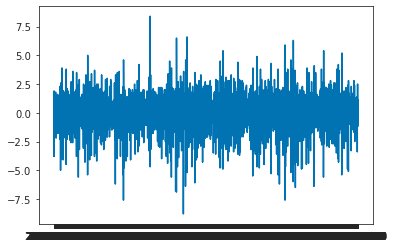

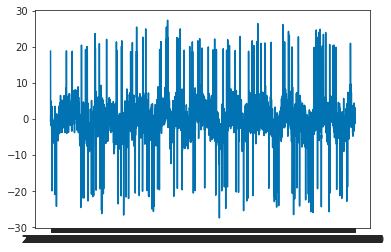

In [53]:
import matplotlib.pyplot as plt

#df_normal_values['TEMP_MAX'] = df_normal_values['TEMP_MAX'].abs()
series = pd.DataFrame(df_normal_values, columns = ['DT_MEDICAO', 'TEMP_MAX'])
series.reset_index(drop=True, inplace=True)

x = series['DT_MEDICAO']
y = series['TEMP_MAX']
plt.plot(x,y)
plt.show()


series = pd.DataFrame(df_training_temp, columns = ['DT_MEDICAO', 'TEMP_MAX'])
series.reset_index(drop=True, inplace=True)

x = series['DT_MEDICAO']
y = series['TEMP_MAX']
plt.plot(x,y)
plt.show()

In [54]:
# TDA magic
import gtda.time_series as time_series
import gtda.homology as hl
import gtda.graphs as gr
from gtda.plotting import plot_diagram, plot_point_cloud
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
import gtda.time_series as ts

In [55]:
data = np.array(df_training_temp)

df_training_temp.head()
df_training_temp.tail()
df_training_temp.shape

df_training_temp.dropna(inplace=True)

df_training_temp['DT_MEDICAO'] = df_training_temp['DT_MEDICAO'].astype('datetime64')

temps_resampled_df = pd.DataFrame(df_training_temp, columns = ['DT_MEDICAO', 'TEMP_MAX'])

#temps_resampled_df['DT_MEDICAO'] = temps_resampled_df['DT_MEDICAO'].astype('datetime64')

temps_resampled_df.set_index('DT_MEDICAO',inplace=True)
temps_values = temps_resampled_df["TEMP_MAX"].tolist()

embedding_series_with_anomalies = time_series.takens_embedding_optimal_parameters(temps_values, 
                                                            max_time_delay=20, 
                                                            max_dimension=20)


print (embedding_series_with_anomalies)

(16, 9)


In [56]:
from gtda.time_series import SingleTakensEmbedding
embedding_time_delay = embedding_series_with_anomalies[0]
embedding_dimension = embedding_series_with_anomalies[1]
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

temps_values_anomalie_embedded = embedder.fit_transform(temps_values)

In [57]:
sliding_window = ts.SlidingWindow(size=30, stride=5)
temps_values_anomalie_windows = sliding_window.fit_transform(temps_values_anomalie_embedded)

In [58]:
persistence = hl.VietorisRipsPersistence(homology_dimensions=(0, 1), n_jobs=-1)
persistences_diagrams_anomalies = persistence.fit_transform(temps_values_anomalie_windows)
#final_embbeded_anomalies = temps_values_anomalie_embedded[None, :, :]


In [59]:
metric_params = {"p": 2, "n_bins": 1000}


bettiHomDer = HomologicalDerivative(
    metric='betti', metric_params=metric_params, order=2, n_jobs=-1
)
betti_succ_dists = bettiHomDer.fit_transform(
    persistences_diagrams_anomalies)

In [60]:
len(temps_values) #Total data

3356

In [61]:
len(temps_values_anomalie_embedded) #Takens Embedded

646

In [62]:
len(temps_values_anomalie_windows) #Sliding Window

124

In [63]:
len(persistences_diagrams_anomalies) #Vietoris Rips

124

In [66]:
len(betti_succ_dists)

123

In [67]:
print (betti_succ_dists)

[ 3.79032194  7.26212852  7.38978192  4.321205    2.95891543  8.81497064
  8.22162087  6.49047597  8.65643598 13.13963803  3.95063713  9.19855734
  8.0200889   5.08938256  5.47026662 12.69304781  8.36745956  5.46563116
 11.14336942  7.12634356  8.05346492  4.14763765  6.43608192  8.04953604
  5.72042995  6.31795838  5.01306806  4.85660984  7.8696029  10.85000289
  5.43192696  6.77824737  4.16083529  6.54622958  5.85854547  9.55741538
  6.84008706  6.19697974  5.71870666  4.6306053  12.15756635  7.67503368
  3.94893512  5.40313667  6.54657854  4.60791293  7.58382337  8.03948056
  8.18289187  7.54163211  4.78897811 10.44748172  3.58471105  9.74724227
  5.15892586  5.17101954  6.24798936  7.22021788  5.40266145  8.22034807
  7.33228585  9.54431267  4.84996624  2.73196358  4.05575695  7.92752717
  6.22707888  8.46963999  5.39167275  7.71571186  6.20044763  6.92354624
  4.3287055   8.41999418 10.79057417  5.67363666 11.16361917  7.11833423
  3.56867055  6.80274828  9.85507977  9.50711343  7

In [ ]:
########

In [ ]:
########

In [ ]:
###Dados sem anomalias##### 

In [68]:
df_normal_values.head()
df_normal_values.tail()
df_normal_values.shape

df_normal_values.dropna(inplace=True)

df_normal_values['DT_MEDICAO'] = df_normal_values['DT_MEDICAO'].astype('datetime64')
df_normal_resampled = pd.DataFrame(df_normal_values, columns = ['DT_MEDICAO', 'TEMP_MAX'])
df_normal_resampled.set_index('DT_MEDICAO',inplace=True)
normal_temps_values = df_normal_resampled["TEMP_MAX"].tolist()


embedding_series_without_anomalies = time_series.takens_embedding_optimal_parameters(normal_temps_values, 
                                                            max_time_delay=20, 
                                                            max_dimension=20)
print (embedding_series_without_anomalies)

(12, 9)


In [69]:
embedding_time_delay = embedding_series_without_anomalies[0]
embedding_dimension = embedding_series_without_anomalies[1]
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="fixed", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

normal_values_embedded = embedder.fit_transform(normal_temps_values)

In [70]:
temps_values_normal_windows = sliding_window.fit_transform(normal_values_embedded)

In [71]:
persistences_diagrams_normal = persistence.fit_transform(temps_values_normal_windows)

In [72]:
distance_diagrams_normal = pairwise_distance.fit_transform(persistences_diagrams_normal)

In [73]:
betti_succ_dists_normal = bettiHomDer.fit_transform(
    persistences_diagrams_normal)

In [74]:
print(betti_succ_dists_normal)

[4.40042085 2.7819312  3.01715921 3.43421329 2.62663191 2.65762422
 5.37376126 3.31564052 3.63071795 2.91290588 2.89590764 2.46591789
 3.27486326 3.40899623 2.28147342 2.40340982 2.98105221 2.74368418
 3.78398931 5.21346349 3.26556935 2.885963   3.47864472 4.44425769
 2.22965513 5.70155234 2.36372536 3.45591456 3.51002672 2.75181845
 3.79744155 2.49534464 4.78056688 2.98745359 2.48986108 2.68847628
 4.09945906 5.61593423 2.65834722 5.04886211 6.45048592 8.13109412
 4.21181182 3.71360367 4.48890936 3.82621815 3.34447135 4.62383694
 4.12530839 5.82366076 5.00626864 4.97224652 4.41515779 3.76254841
 5.42445732 3.38994002 6.43765441 5.90869098 5.41477842 5.4128568
 2.47203416 2.70873883 3.16907521 6.22022765 3.00756845 3.25294717
 2.79090962 3.47881318 2.80508285 3.44112463 4.7595052  6.34390121
 5.50739266 2.19356383 4.72000214 2.88365724 3.31281544 2.89403966
 6.36623248 2.37178092 3.26988288 3.45088896 5.27393504 4.85798076
 3.35589055 3.05593952 5.09581356 3.14120748 5.70162419 3.14347